# Diversity and Ability
This notebook contains code that supports the analysis of the diversity-expertise tradeoff. The first part analyses the simulation data. The second part provides some numerical examples and a more detailed analysis aimed at providing explanations for the simulation results.  

## Setup

In [ ]:
import os
from math import comb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import stats

from data_analysis.statistics import produce_df_1samp, produce_df_paired
from figures.generate_heatmap import heatmap
from models.agent import Agent
from models.generate_teams import (
    generate_diverse_team,
    generate_expert_team,
    generate_qualified_diverse_team,
)
from models.sources import Sources
from models.team import Team
from utils.basic_functions import powerset

In [17]:
translate_outcome_mechanism: dict = {
    "accuracy_opinion": "opinion-based mechanism",
    "accuracy_evidence": "evidence-based mechanism",
    "accuracy_bounded": "boundedly-rational evidence-based mechanism"
}

def df_to_latex(
        df: pd.DataFrame, 
        latex_file: str | None = None, 
        outcome: str = "accuracy_opinion",
    ) -> None:
    if latex_file is None:
        raise ValueError("Please provide a valid filename for the LaTeX file.")
    
    if not latex_file.endswith('.tex'):
        latex_file += '.tex'
    
    latex_file = f"data_analysis/tables/{latex_file}"
    
    cols = list(df.columns)
    df.loc[:, "rel_mean"] = df["rel_mean"] * 100
    df.loc[:, "difference"] = df["difference"] * 100
    df.loc[:, "ci_low"] = df["ci_low"] * 100
    df.loc[:, "ci_high"] = df["ci_high"] * 100
    formats = {
        "n_sources": "{:.0f}".format,
        "rel_mean": "{:.0f}".format,
        "difference": "{:.1f}".format,
        "error_reduction": "{:.1f}".format,
        "p_value": "{:.3f}".format,
        "effect_size": "{:.2f}".format,
        "ci_low": "{:.1f}".format,
        "ci_high": "{:.1f}".format,
        "ratio": "{:.2f}".format,
    }
    
    cols.remove('ties')
    header_dict: dict ={
        "n_sources": "Sources",
        "rel_mean": "Rel.\\ (mean)",
        "difference": "Diff.\\ (abs.)",
        "error_reduction": "Diff.\\ (rel.)",
        "p_value": "p-value",
        "effect_size": "Effect",
        "ci_low": f"CI-",
        "ci_high": f"CI+",
        "ratio": "Ratio"
    }
    header = [header_dict[col] for col in cols]

    captiontext = f"Results of the Wilcoxon signed-rank test for the {translate_outcome_mechanism[outcome]}."
    
    df.to_latex(
        latex_file, 
        index=False, 
        columns=cols, 
        header=header, 
        formatters=formats, 
        caption=captiontext, 
        position="htb", 
        label=f"tab:app-{outcome.split("_")[1]}")

    with open(latex_file, 'r') as file:
        lines = file.readlines()
    # Add centering
    lines.insert(1, '\\centering\n')
    # Move caption and label to end
    caption_line = lines.pop(2)
    label_line = lines.pop(2)
    lines.insert(-1, caption_line)
    lines.insert(-1, label_line)

    with open(latex_file, 'w') as file:
        file.writelines(lines)

# Statistics and heatmaps
To be conservative, we use a *non-parametric* statistical test: the Wilcoxon test ([Wikipedia](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)). When comparing the expert team to a set of diverse teams, we use the one-sample Wilcoxon test. When comparing the performance of the diverse team for different deliberative mechanisms, we use the paired Wilcoxon test.

For each parameter setting, we report:
- the difference in the medians, 
- error reduction,

and, if applicable,

- p-value, 
- effect size (Cohen's $r$), 
- 95%-confidence interval (bootstrap method with 20,000 resamples, we report the 2.5th and 97.5th percentiles of the bootstrap distribution as the lower and upper limits),
- whether there were any tied ranks, and
- the ratio (proportion) of differences with the dominant sign.

## Results in tabular form

In [10]:
for outcome in ["accuracy_opinion", "accuracy_evidence", "accuracy_bounded"]:
    print("="*40)
    print(f"{translate_outcome_mechanism[outcome].capitalize()}")
    print("="*40)
    df_results = produce_df_1samp(outcome)
    if "evidence" not in outcome: 
        df_to_latex(df_results, latex_file=f"table_{outcome}.tex", outcome=outcome)
    display(df_results)

Opinion-based mechanism


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,55.0,-8.1,-28.6,0.0000,0.866,-8.082896,-8.038065,False,1.0000
1,13,60.0,-4.3,-21.9,0.0000,0.866,-4.328039,-4.295748,False,1.0000
2,13,65.0,-1.5,-12.1,0.0000,0.866,-1.536634,-1.509574,False,0.9998
3,13,70.0,0.0,0.1,0.1626,0.014,-0.003651,0.015254,False,0.5064
4,13,75.0,0.5,15.3,0.0000,0.863,0.459690,0.470242,False,0.9792
5,17,55.0,-8.3,-31.6,0.0000,0.866,-8.358316,-8.309678,False,1.0000
6,17,60.0,-3.3,-18.2,0.0000,0.866,-3.329201,-3.296096,False,1.0000
7,17,65.0,-0.0,-0.3,0.0000,0.087,-0.047865,-0.023740,False,0.5278
8,17,70.0,1.3,24.9,0.0000,0.866,1.268920,1.283550,False,1.0000
9,17,75.0,1.2,66.8,0.0000,0.866,1.200509,1.207058,False,1.0000


Evidence-based mechanism


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,-0.054,-17.7,NaN,NaN,NaN,NaN,False,NaN
1,13,0.60,-0.027,-13.4,NaN,NaN,NaN,NaN,False,NaN
2,13,0.65,-0.008,-6.6,NaN,NaN,NaN,NaN,False,NaN
3,13,0.70,0.002,2.7,NaN,NaN,NaN,NaN,False,NaN
4,13,0.75,0.004,15.8,NaN,NaN,NaN,NaN,False,NaN
5,17,0.55,-0.070,-26.4,NaN,NaN,NaN,NaN,False,NaN
6,17,0.60,-0.026,-15.1,NaN,NaN,NaN,NaN,False,NaN
7,17,0.65,0.001,0.8,NaN,NaN,NaN,NaN,False,NaN
8,17,0.70,0.010,24.7,NaN,NaN,NaN,NaN,False,NaN
9,17,0.75,0.008,66.0,NaN,NaN,NaN,NaN,False,NaN


Boundedly-rational evidence-based mechanism


,n_sources,rel_mean,difference,error_reduction,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,55.0,-7.4,-26.4,0.0,0.866,-7.431051,-7.427483,False,1.0000
1,13,60.0,-3.1,-15.9,0.0,0.866,-3.146838,-3.139910,False,1.0000
2,13,65.0,-0.2,-1.8,0.0,0.774,-0.229836,-0.221073,False,0.8677
3,13,70.0,1.1,17.6,0.0,0.866,1.087579,1.094257,False,1.0000
4,13,75.0,1.2,48.7,0.0,0.866,1.156880,1.160289,False,1.0000
5,17,55.0,-7.5,-28.3,0.0,0.866,-7.494850,-7.484801,False,1.0000
6,17,60.0,-1.9,-10.6,0.0,0.866,-1.944626,-1.925318,False,1.0000
7,17,65.0,1.3,13.2,0.0,0.866,1.335299,1.353337,False,0.9992
8,17,70.0,2.3,54.6,0.0,0.866,2.281052,2.292375,False,1.0000
9,17,75.0,1.7,133.2,0.0,0.866,1.740033,1.744931,False,1.0000


## Heatmaps

Opinion-based mechanism


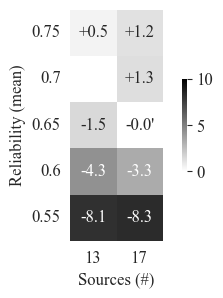

Evidence-based mechanism


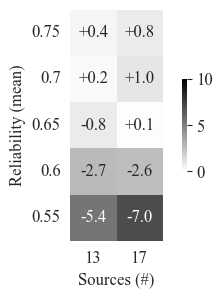

Boundedly-rational evidence-based mechanism


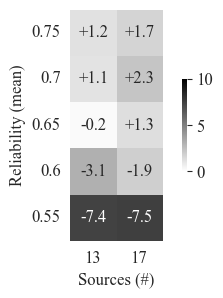

In [4]:
for outcome in ["accuracy_opinion", "accuracy_evidence", "accuracy_bounded"]:
    print("="*40)
    print(f"{translate_outcome_mechanism[outcome].capitalize()}")
    print("="*40)
    heatmap(outcome=outcome, show=True)

Opinion-based mechanism


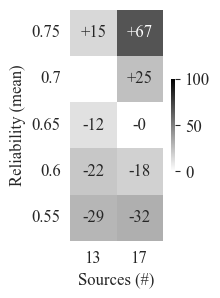

Evidence-based mechanism


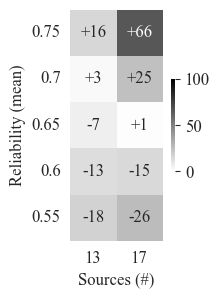

Boundedly-rational evidence-based mechanism


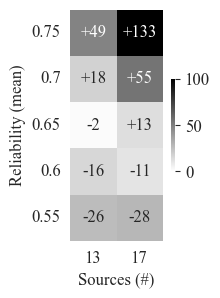

In [4]:
for outcome in ["accuracy_opinion", "accuracy_evidence", "accuracy_bounded"]:
    print("="*40)
    print(f"{translate_outcome_mechanism[outcome].capitalize()}")
    print("="*40)
    heatmap(outcome=outcome, measure="relative", show=True)

# Explanations for the results

## Some examples
In this section, we treat some examples to demonstrate that diversity sometimes trumps expertise, and _vice versa_.

Numerical example with a few highly reliable and the others are randomizers

In [9]:
sources = Sources(18)
reliabilities = 0.50* np.ones(14) 
reliabilities = np.append(reliabilities, [0.9, 0.9, 0.9, 0.9])
sources.reliabilities = reliabilities
team_size = 3
e_team = generate_expert_team(sources, 3, team_size)
d_team = generate_diverse_team(sources, 3, team_size)
print(f"Expert team accuracy opinion: {e_team.accuracy_opinion()[0]:.3f}")
print(f"Diverse team accuracy opinion: {d_team.accuracy_opinion()[0]:.3f}")
print(f"Expert team accuracy evidence: {e_team.accuracy_evidence():.3f}")
print(f"Diverse team accuracy evidence: {d_team.accuracy_evidence():.3f}")
print(f"Expert team accuracy bounded evidence: {e_team.accuracy_bounded()[0]:.3f}")
print(f"Diverse team accuracy bounded evidence: {d_team.accuracy_bounded()[0]:.3f}")

Expert team accuracy opinion: 0.972
Diverse team accuracy opinion: 0.800
Expert team accuracy evidence: 0.972
Diverse team accuracy evidence: 0.818
Expert team accuracy bounded evidence: 0.972
Diverse team accuracy bounded evidence: 0.818


Numerical example where sources are approximately equally reliable.

In [11]:
sources = Sources(18)
reliabilities = 0.59* np.ones(14) 
reliabilities = np.append(reliabilities, 0.6 * np.ones(4))
sources.reliabilities = reliabilities
team_size = 3
e_team = generate_expert_team(sources, 3, team_size)
d_team = generate_diverse_team(sources, 3, team_size)
print(f"Expert team accuracy opinion: {e_team.accuracy_opinion()[0]:.3f}")
print(f"Diverse team accuracy opinion: {d_team.accuracy_opinion()[0]:.3f}")
print(f"Expert team accuracy evidence: {e_team.accuracy_evidence():.3f}")
print(f"Diverse team accuracy evidence: {d_team.accuracy_evidence():.3f}")
print(f"Expert team accuracy bounded: {e_team.accuracy_bounded()[0]:.3f}")
print(f"Diverse team accuracy bounded: {d_team.accuracy_bounded()[0]:.3f}")

Expert team accuracy opinion: 0.648
Diverse team accuracy opinion: 0.700
Expert team accuracy evidence: 0.648
Diverse team accuracy evidence: 0.717
Expert team accuracy bounded: 0.648
Diverse team accuracy bounded: 0.717


Justifying the decision to consider reliability means of maximally 75%. Calculating the highest individual score for this setting. 

In [12]:
sources = Sources(21, reliability_distribution=("equidist", 0.75, 0.2))
e_team = generate_expert_team(sources, 5, 9)

for agent in e_team.members:
    print(f"Score: {agent.score:.5f}")

Score: 0.96269
Score: 0.96155
Score: 0.96041
Score: 0.96035
Score: 0.95927
Score: 0.95919
Score: 0.95910
Score: 0.95813
Score: 0.95802


## Individual scores
In this section, we study the individual scores in different parameter settings. Our analysis shows that we can interpret the parameter settings in multiple ways: in terms of the sources’ reliabilities, the problem’s difficulty, and/or the knowledge and skills of the pool of agents. 

In [1]:
from figures.individual_scores import df_individual_scores, boxplot_individual_scores

A visualization of the distribution of individual scores of all possible heuristics

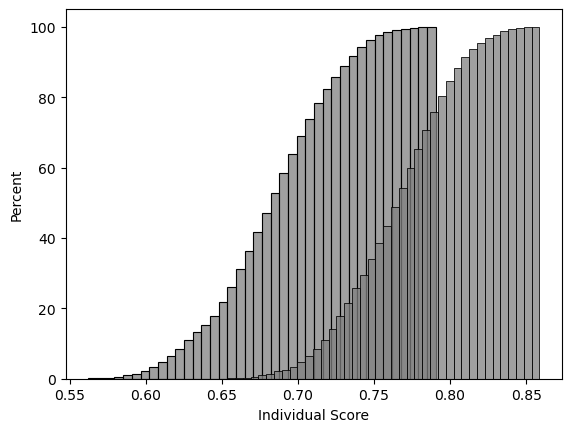

In [ ]:
from math import comb

n_sources = 13
for rel_mean in [0.6, 0.65]:
    sources = Sources(n_sources, reliability_distribution=("equidist", rel_mean, 0.2))

    ranked_agents = generate_expert_team(sources, 5, comb(n_sources, 5))

    scores = np.array([agent.score for agent in ranked_agents.members])
    fig = sns.histplot(scores, bins= 40, stat="percent", cumulative=True, color="gray")
    fig.set_xlabel("Individual Score")

In [2]:
df_individual_scores()

,n_sources,rel_mean,mean,min,5th_pct,25th_pct,75th_pct,95th_pct,max,std
0,13,55,59.3,46.9,52.5,56.3,62.4,66.0,71.1,4.2
5,17,55,59.3,45.3,51.9,56.1,62.5,66.6,72.5,4.4
1,13,60,68.3,56.2,61.8,65.5,71.2,74.6,79.0,3.9
6,17,60,68.3,54.7,61.2,65.3,71.3,75.0,80.2,4.1
2,13,65,76.5,65.4,70.6,74.0,79.2,82.1,85.9,3.5
7,17,65,76.5,63.9,70.1,73.9,79.2,82.4,86.9,3.7
3,13,70,83.8,73.9,78.6,81.7,86.0,88.4,91.4,3.0
8,17,70,83.8,72.5,78.2,81.6,86.0,88.7,92.1,3.2
4,13,75,89.7,81.5,85.5,88.1,91.5,93.4,95.4,2.4
9,17,75,89.7,80.2,85.2,88.1,91.6,93.5,96.0,2.5


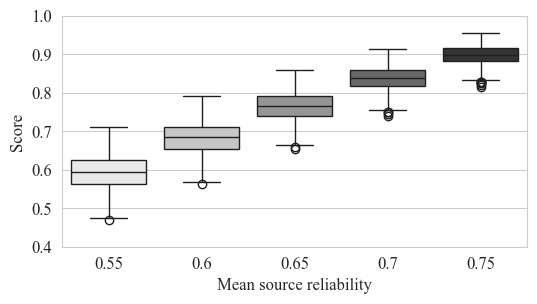

In [2]:
boxplot_individual_scores(show=True)

## Opinion-based dynamics

### Individual performance difference, diversity and disagreement

In this section, we determine
1. The individual performance difference between members of the expert team and of the diverse teams;
2. The difference in diversity between the expert and diverse team; and 
3. The rate of disagreement between experts. We show that the expert team is very homogenous and that disagreement between experts is rare. 

In [ ]:
import itertools
import numpy as np
import pandas as pd

from math import comb

import utils.config as cfg
from utils.basic_functions import calculate_diversity

from models.sources import Sources
from models.agent import Agent
from models.generate_teams import generate_expert_team, generate_diverse_team

from figures.generate_heatmap import heatmap


The performance difference of individual members. 

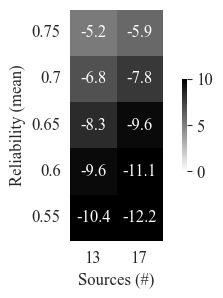

In [7]:
heatmap(outcome="average", measure="absolute", show=True)

The difference in diversity between the expert and the diverse team.

In [8]:
sources = Sources(13)
e_team = generate_expert_team(sources, 5, 9)
d_team = generate_diverse_team(sources, 5, 9)
e_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in e_team.members for b in e_team.members]
d_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in d_team.members for b in d_team.members]
print(f"Diversity gap for 13 sources {d_team.diversity() - e_team.diversity():.3f}")

sources = Sources(17)
e_team = generate_expert_team(sources, 5, 9)
d_team = generate_diverse_team(sources, 5, 9)
e_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in e_team.members for b in e_team.members]
d_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in d_team.members for b in d_team.members]
print(f"Diversity gap for 17 sources {d_team.diversity() - e_team.diversity():.3f}")



Diversity gap for 13 sources 0.406
Diversity gap for 17 sources 0.506


The minimum correlation among experts

In [9]:
def compute_correlation_agreement(agent1: Agent, agent2: Agent) -> tuple[float, float]:
    sources = agent1.sources
    sources_relevant = np.unique(agent1.heuristic + agent2.heuristic)
    
    p_both_correct: float = 0.0    
    p_agreement: float = 0.0
    for configuration in itertools.product([0,1], repeat=len(sources_relevant)):
        for source in sources.sources:
            sources.set_valence(source, cfg.vote_for_negative)
        for source, bit in zip(sources_relevant, configuration):
            if bit == 1:
                sources.set_valence(source, cfg.vote_for_positive)
        agent1.update_opinion()
        agent2.update_opinion()
        if agent1.opinion == agent2.opinion:
            p_configuration = 1.0
            for source, bit in zip(sources_relevant, configuration):
                source_rel = sources.reliabilities[source]
                p_configuration *= source_rel if bit == 1 else (1 - source_rel)
            p_agreement += p_configuration
            if agent1.opinion == cfg.vote_for_positive:
                p_both_correct += p_configuration
        
    p_1_correct = agent1.score
    p_2_correct = agent2.score
    corr = (p_both_correct - p_1_correct * p_2_correct) / np.sqrt(p_1_correct * (1 - p_1_correct) * p_2_correct * (1 - p_2_correct))
    return corr, p_agreement

In [11]:
def compute_expert_correlation_agreement(n_sources, rel_mean):
    sources = Sources(n_sources, ("equi", rel_mean, 0.2))
    e_team = generate_expert_team(sources, 5, 9)
    results = [compute_correlation_agreement(a, b) for a in e_team.members for b in e_team.members if a != b]
    correlations = [item[0] for item in results]
    average_correlation = np.mean(correlations)
    agreement_rates = [item[1] for item in results]
    agreement_min = min(agreement_rates)
    return average_correlation, agreement_min
    

In [12]:
data = [
    [
        n_sources, 
        rel_mean, 
        round(compute_expert_correlation_agreement(n_sources, rel_mean)[0], 3),
        round(compute_expert_correlation_agreement(n_sources, rel_mean)[1]*100, 1)
    ]
    for n_sources in [13, 17]
    for rel_mean in 0.55 + 0.05 * np.arange(5)
]
df = pd.DataFrame(data, columns=["sources (#)", "reliability (mean)", "correlation (mean)", "agreement (min)"])
df


,sources (#),reliability (mean),correlation (mean),agreement (min)
0,13,0.55,0.537,75.3
1,13,0.60,0.521,79.0
2,13,0.65,0.499,83.5
3,13,0.70,0.469,88.4
4,13,0.75,0.430,92.9
5,17,0.55,0.535,76.0
6,17,0.60,0.519,80.0
7,17,0.65,0.496,84.6
8,17,0.70,0.466,89.4
9,17,0.75,0.427,93.8


## Expert team versus best-performing individual
In this section, we compare the performance of the expert team and the best-performing _individual_ for the opinion-based dynamics and the boundedly-rational evidence-based dynamics. We show that the difference is tiny, indicating that the expert team and the best-performing individual are virtually identical. 

In [13]:
from data_analysis.statistics import produce_df_paired

In [14]:
produce_df_paired(compute_ci=True)

,n_sources,rel_mean,difference,p_value,effect_size,ci_low,ci_high,ties,ratio
0,13,0.55,0.001,0.0,0.289243,0.001,0.001,False,0.6259
1,13,0.60,0.002,0.0,0.528241,0.002,0.002,False,0.7252
2,13,0.65,0.002,0.0,0.674848,0.002,0.002,False,0.8008
3,13,0.70,0.001,0.0,0.751502,0.001,0.001,False,0.8497
4,13,0.75,0.001,0.0,0.803781,0.001,0.001,False,0.8906
5,17,0.55,0.003,0.0,0.381610,0.003,0.003,False,0.6558
6,17,0.60,0.005,0.0,0.655011,0.005,0.005,False,0.7876
7,17,0.65,0.005,0.0,0.776076,0.004,0.005,False,0.8689
8,17,0.70,0.003,0.0,0.835062,0.003,0.003,False,0.9260
9,17,0.75,0.002,0.0,0.852949,0.002,0.002,False,0.9515


In [15]:
from data_analysis.expert_team_vs_individual import produce_df_expert_team_individual

In [18]:
for outcome in ["accuracy_opinion", "accuracy_bounded"]:
    print("="*40)
    print(translate_outcome_mechanism[outcome].capitalize())
    print("="*40)
    display(produce_df_expert_team_individual(outcome))

Opinion-based mechanism


,n_sources,rel_mean,difference,error_reduction
0,13,0.55,-0.007,-2
1,13,0.60,-0.013,-6
2,13,0.65,-0.015,-12
3,13,0.70,-0.014,-20
4,13,0.75,-0.011,-30
5,17,0.55,-0.011,-4
6,17,0.60,-0.016,-9
7,17,0.65,-0.017,-15
8,17,0.70,-0.015,-23
9,17,0.75,-0.010,-34


Boundedly-rational evidence-based mechanism


,n_sources,rel_mean,difference,error_reduction
0,13,0.55,-0.007,-2
1,13,0.60,-0.012,-6
2,13,0.65,-0.015,-12
3,13,0.70,-0.014,-19
4,13,0.75,-0.010,-29
5,17,0.55,-0.011,-4
6,17,0.60,-0.015,-8
7,17,0.65,-0.016,-14
8,17,0.70,-0.014,-22
9,17,0.75,-0.010,-32


## Overcounting: Boundedly rational evidence-based dynamics
In this section, we study the boundedly rational evidence-based dynamics and, in particular, the exact weights in expert teams and diverse teams. We show that 
1. The expert team puts virtually all the weight on the best evidences, while the diverse team spreads the weight (approximately) equally among all evidences; and
2. The performance difference between diverse teams are tiny when comparing the evidence-based dynamics to the boundedly-rational evidence-based dynamics. 

In [34]:
from models.generate_teams import generate_expert_team, generate_diverse_team

sources = Sources(17)
e_team = generate_expert_team(sources, 5, 9)

expert_coverage, expert_weights = np.unique([agent.heuristic for agent in e_team.members], return_counts=True)
pd.Series(dict(zip(expert_coverage, expert_weights)))

8     1
9     2
10    2
11    3
12    5
13    6
14    8
15    9
16    9
dtype: int64

In [37]:
d_team = generate_diverse_team(sources, 5, 9)

coverage, weights = np.unique([agent.heuristic for agent in d_team.members], return_counts=True)
pd.Series(dict(zip(coverage, weights)))

0     2
1     3
2     3
3     3
4     2
5     3
6     3
7     3
8     3
9     2
10    2
11    3
12    3
13    3
14    2
15    3
16    2
dtype: int64